In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/457-data/SP 500 Historical Data.csv
/kaggle/input/457-data/final_df1.csv
/kaggle/input/457-data/Cushing_OK_WTI_Spot_Price_FOB.csv
/kaggle/input/457-data/Ghana_data.csv
/kaggle/input/457-data/Daily Prices_ICCO.csv
/kaggle/input/457-data/SP 500 Historical Data 2.csv
/kaggle/input/457-data/Confectionery Product Manufacturing.csv
/kaggle/input/ghana-data/Ghana_data.csv


In [2]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 12.8 MB/s eta 0:00:0000:010:01


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from arch import arch_model
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from scipy.signal import periodogram
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set(rc={'figure.figsize':(15, 8)})


In [4]:
# Define utility functions for standardized visualizations

def set_plotting_style():
    """Set consistent plotting style for all visualizations."""
    plt.style.use('seaborn-v0_8')
    sns.set_style("whitegrid")
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['legend.fontsize'] = 12
    plt.rcParams['figure.titlesize'] = 18

def plot_forecast(train, test, forecast, model_name, target_col='icco_daily_price', 
                  confidence_intervals=None, figsize=(15, 8)):
    """
    Standardized function for plotting forecasts with consistent formatting.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot training data
    ax.plot(train.index, train[target_col], label='Training Data', color='#1f77b4', linewidth=1.5)
    
    # Plot test data
    ax.plot(test.index, test[target_col], label='Actual Test Data', color='#2ca02c', linewidth=1.5)
    
    # Plot forecast
    ax.plot(test.index, forecast, label='Forecast', color='#d62728', linewidth=1.5)
    
    # Add confidence intervals if provided
    if confidence_intervals is not None:
        lower_ci, upper_ci = confidence_intervals
        ax.fill_between(test.index, lower_ci, upper_ci, color='#d62728', alpha=0.2, label='95% Confidence Interval')
    
    # Format the plot
    ax.set_title(f'{model_name} - Forecast vs Actual', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price (US$/tonne)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=12)
    
    # Format y-axis with comma separator for thousands
    ax.yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
    
    # Format x-axis dates
    from matplotlib.dates import DateFormatter
    import matplotlib.dates as mdates
    date_format = DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    
    # Save the figure using the model name
    plt.savefig(f"{model_name.replace(' ', '_').lower()}_forecast.png", dpi=300, bbox_inches='tight')

    return fig

def plot_model_comparison(metrics_df, metric_name, figsize=(12, 6), highlight_best=True):
    """
    Create standardized bar charts for model comparison.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Sort values for better visualization
    if metric_name.upper() in ['RMSE', 'MAPE', 'RMSLE', 'MAE']:
        # Lower is better
        sorted_df = metrics_df.sort_values(metric_name)
        best_idx = 0  # First model after sorting
    else:
        # Higher is better (R^2)
        sorted_df = metrics_df.sort_values(metric_name, ascending=False)
        best_idx = 0  # First model after sorting
    
    # Set colors
    colors = ['skyblue'] * len(sorted_df)
    if highlight_best:
        colors[best_idx] = 'green'
    
    # Create bar chart
    bars = ax.bar(sorted_df.index, sorted_df[metric_name], color=colors)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01*max(sorted_df[metric_name]),
                f'{height:.4f}', ha='center', va='bottom', fontsize=10)
    
    # Format the plot
    ax.set_title(f'Model Comparison - {metric_name}', fontsize=16)
    ax.set_ylabel(metric_name, fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    return fig



# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    """Calculate performance metrics for model evaluation."""
    # Remove zeros from y_true to avoid division by zero in MAPE
    mask = y_true != 0
    y_true_mape = y_true[mask]
    y_pred_mape = y_pred[mask]
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # For RMSLE, ensure all values are positive
    y_true_log = np.maximum(y_true, 0.1)
    y_pred_log = np.maximum(y_pred, 0.1)
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_true_log), np.log1p(y_pred_log)))
    
    # MAPE calculation
    if len(y_true_mape) > 0:
        mape = np.mean(np.abs((y_true_mape - y_pred_mape) / y_true_mape)) * 100
    else:
        mape = np.nan
    
    # R-squared
    r2 = r2_score(y_true, y_pred)
    
    return {
        'RMSE': rmse,
        'RMSLE': rmsle,
        'MAPE': mape,
        'R^2': r2
    }

def create_metrics_table(metrics_dict, precision=4):
    """
    Create a formatted DataFrame from metrics dictionary.
    """
    # Create DataFrame
    metrics_df = pd.DataFrame(metrics_dict).T
    
    # Round values
    metrics_df = metrics_df.round(precision)
    
    # Sort by RMSE (or first column if RMSE not present)
    if 'RMSE' in metrics_df.columns:
        metrics_df = metrics_df.sort_values('RMSE')
    else:
        metrics_df = metrics_df.sort_values(metrics_df.columns[0])
    
    return metrics_df


In [5]:
# Set the plotting style
set_plotting_style()

# Define paths for data loading
try:
    # Try Kaggle path first
    base_path = "../input/457-data/"
    final_df1 = pd.read_csv(f"{base_path}final_df1.csv")
    ghana_df = pd.read_csv(f"{base_path}Ghana_data.csv")
    print(f"Successfully loaded data from Kaggle path")
except:
    print(f"Could not load data from Kaggle path")

Successfully loaded data from Kaggle path


In [6]:
# Display basic information about the datasets
print("final_df1 Dataset Shape:", final_df1.shape)
print("Ghana Dataset Shape:", ghana_df.shape)

print("\nfinal_df1 First few rows:")
final_df1.head()

final_df1 Dataset Shape: (7363, 5)
Ghana Dataset Shape: (53231, 7)

final_df1 First few rows:


,Date,icco_daily_price,cnft_price,oil_price,sp500_change
0,1995-10-03,1372.80,124.1,17.56,0.10
1,1995-10-04,1381.55,124.1,17.32,-0.14
2,1995-10-05,1375.45,124.1,16.86,0.19
3,1995-10-06,1373.33,124.1,17.03,-0.02
4,1995-10-09,1375.14,124.1,17.36,-0.70


In [7]:
# Display Ghana data
print("\nGhana Data First few rows:")
ghana_df.head()


Ghana Data First few rows:


,STATION,NAME,DATE,PRCP,TAVG,TMAX,TMIN
0,GHM00065472,"KOTOKA INTERNATIONAL, GH",1990-01-01,NaN,80,91.0,76.0
1,GHM00065472,"KOTOKA INTERNATIONAL, GH",1990-01-02,NaN,81,92.0,NaN
2,GHM00065472,"KOTOKA INTERNATIONAL, GH",1990-01-03,NaN,82,NaN,NaN
3,GHM00065472,"KOTOKA INTERNATIONAL, GH",1990-01-04,NaN,81,NaN,75.0
4,GHM00065472,"KOTOKA INTERNATIONAL, GH",1990-01-05,0.0,79,89.0,75.0


In [8]:
# Preprocess final_df1 data
def preprocess_final_df1(df):
    """Preprocess final_df1 dataset."""
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Convert date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Set date as index
    df.set_index('Date', inplace=True)
    
    # Sort by date
    df = df.sort_index()
    
    # Check for duplicate dates
    duplicates = df.index.duplicated()
    if duplicates.any():
        print(f"Found {duplicates.sum()} duplicate dates in final_df1. Keeping the first occurrence.")
        df = df[~df.index.duplicated(keep='first')]
    
    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print(f"Filling {missing_values.sum()} missing values in final_df1...")
        df = df.fillna(method='ffill').fillna(method='bfill')
    
    return df

# Preprocess Ghana climate data
def preprocess_ghana_data(df):
    """Preprocess Ghana climate data."""
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Convert date column to datetime
    df['Date'] = pd.to_datetime(df['DATE'])
    
    # Set date as index
    df.set_index('Date', inplace=True)
    
    # Sort by date
    df = df.sort_index()

    # Remove TMAX, TMIN, and NAME columns if they exist
    columns_to_remove = ['TMAX', 'TMIN', 'NAME', 'STATION']
    for col in columns_to_remove:
        if col in df.columns:
            print(f"Removing column {col} from Ghana data")
            df = df.drop(columns=[col])
    
    # Check for duplicate dates
    duplicates = df.index.duplicated()
    if duplicates.any():
        print(f"Found {duplicates.sum()} duplicate dates in Ghana data. Keeping the first occurrence.")
        df = df[~df.index.duplicated(keep='first')]
    
    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print(f"Filling {missing_values.sum()} missing values in Ghana data...")
        df = df.fillna(method='ffill').fillna(method='bfill')
    
    # Rename columns for clarity
    df = df.rename(columns={
        'Precipitation': 'Ghana_Precipitation',
        'Temp_Avg': 'Ghana_Temp_Avg',
        'Temp_Min': 'Ghana_Temp_Min',
        'Temp_Max': 'Ghana_Temp_Max'
    })
    
    return df

# Preprocess the datasets
final_df1_processed = preprocess_final_df1(final_df1)
ghana_processed = preprocess_ghana_data(ghana_df)

print("Processed final_df1 shape:", final_df1_processed.shape)
print("Processed Ghana data shape:", ghana_processed.shape)


Found 4 duplicate dates in final_df1. Keeping the first occurrence.
Removing column TMAX from Ghana data
Removing column TMIN from Ghana data
Removing column NAME from Ghana data
Removing column STATION from Ghana data
Found 42287 duplicate dates in Ghana data. Keeping the first occurrence.
Filling 7653 missing values in Ghana data...
Processed final_df1 shape: (7359, 4)
Processed Ghana data shape: (10944, 3)


In [9]:
# Merge the datasets
def merge_datasets(df1, df2):
    """Merge two dataframes on their datetime index."""
    # Merge on index (date)
    merged_df = pd.merge(df1, df2, left_index=True, right_index=True, how='outer')
    
    # Handle missing values in merged dataframe
    print(f"Merged dataframe shape before handling missing values: {merged_df.shape}")
    print(f"Missing values in merged dataframe: {merged_df.isnull().sum().sum()}")
    
    # Fill missing values
    merged_df = merged_df.fillna(method='ffill').fillna(method='bfill')
    print(f"Merged dataframe shape after handling missing values: {merged_df.shape}")
    print(f"Missing values after filling: {merged_df.isnull().sum().sum()}")
    
    return merged_df

# Merge final_df1 and Ghana data
merged_df = merge_datasets(final_df1_processed, ghana_processed)

# Display the first few rows of the merged dataframe
merged_df.head()


Merged dataframe shape before handling missing values: (11946, 7)
Missing values in merged dataframe: 21354
Merged dataframe shape after handling missing values: (11946, 7)
Missing values after filling: 0


,icco_daily_price,cnft_price,oil_price,sp500_change,DATE,PRCP,TAVG
Date,,,,,,,
1990-01-01,1372.8,124.1,17.56,0.1,1990-01-01,0.0,80.0
1990-01-02,1372.8,124.1,17.56,0.1,1990-01-02,0.0,81.0
1990-01-03,1372.8,124.1,17.56,0.1,1990-01-03,0.0,82.0
1990-01-04,1372.8,124.1,17.56,0.1,1990-01-04,0.0,81.0
1990-01-05,1372.8,124.1,17.56,0.1,1990-01-05,0.0,79.0


In [10]:
# Check data types and summary statistics
print("Data Types:")
print(merged_df.dtypes)
print("\nSummary Statistics:")
merged_df.describe()

Data Types:
icco_daily_price    float64
cnft_price          float64
oil_price           float64
sp500_change        float64
DATE                 object
PRCP                float64
TAVG                float64
dtype: object

Summary Statistics:


,icco_daily_price,cnft_price,oil_price,sp500_change,PRCP,TAVG
count,11946.000000,11946.000000,11946.000000,11946.000000,11946.000000,11946.000000
mean,2246.588047,172.957033,52.181179,0.054093,0.191815,81.006111
std,1250.550553,44.201304,29.542926,1.074303,0.516163,3.208331
min,774.100000,124.100000,-36.980000,-11.980000,0.000000,67.000000
25%,1447.750000,129.000000,22.557500,-0.340000,0.000000,79.000000
50%,2080.195000,166.300000,49.815000,0.100000,0.000000,81.000000
75%,2640.930000,203.900000,74.990000,0.490000,0.160000,83.000000
max,11984.660000,308.057000,145.310000,11.590000,12.130000,94.000000


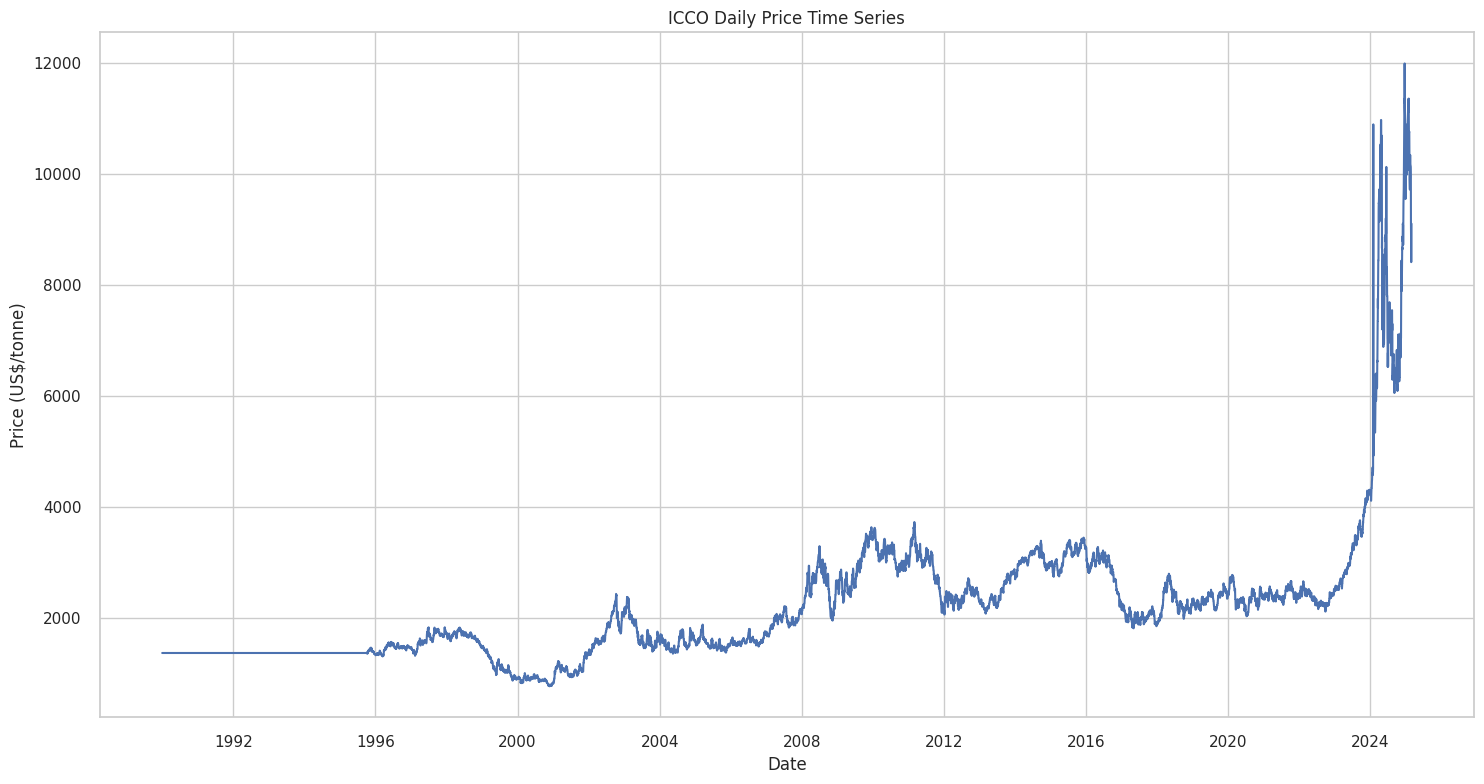

In [32]:
# Plot the ICCO price time series
plt.figure(figsize=(15, 8))
plt.plot(merged_df.index, merged_df['icco_daily_price'])
plt.title('ICCO Daily Price Time Series')
plt.xlabel('Date')
plt.ylabel('Price (US$/tonne)')
plt.grid(True)
plt.tight_layout()
plt.savefig("icco_price_timeseries.png", dpi=300, bbox_inches='tight')
plt.show()


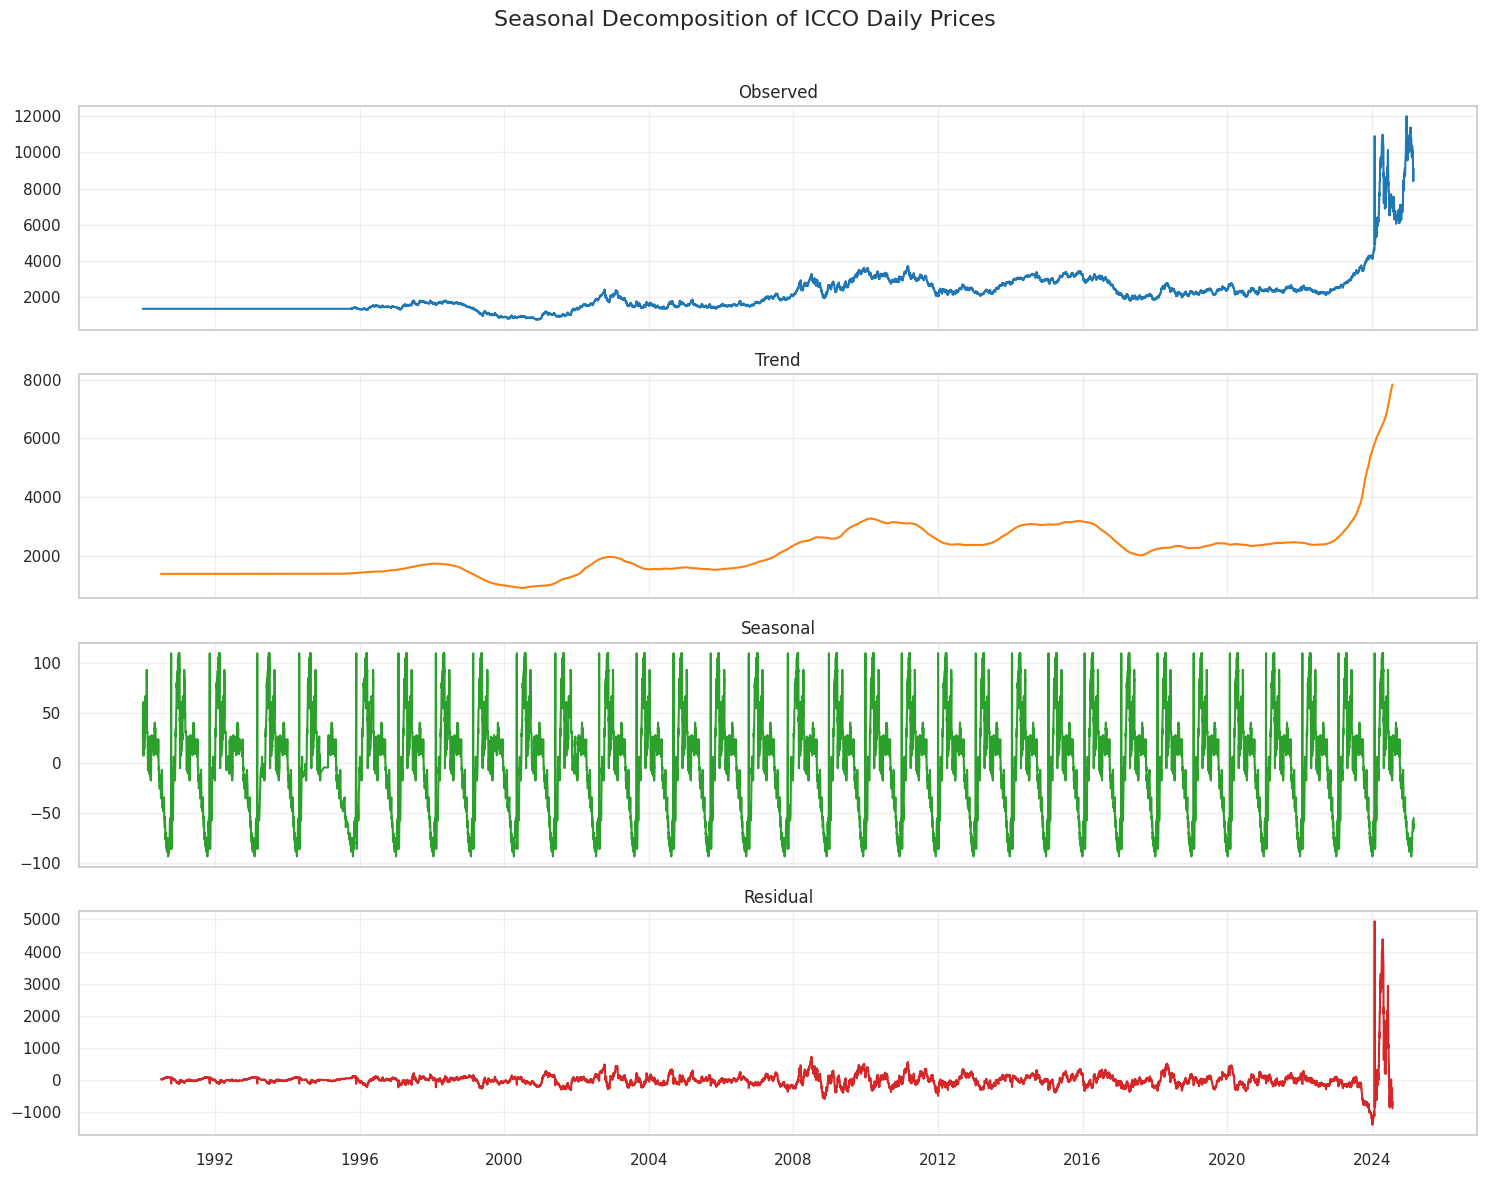

In [33]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(merged_df['icco_daily_price'], model='additive', period=365)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

# Plot observed data
axes[0].plot(decomposition.observed, color='#1f77b4')
axes[0].set_title('Observed')
axes[0].grid(True, alpha=0.3)

# Plot trend component
axes[1].plot(decomposition.trend, color='#ff7f0e')
axes[1].set_title('Trend')
axes[1].grid(True, alpha=0.3)

# Plot seasonal component
axes[2].plot(decomposition.seasonal, color='#2ca02c')
axes[2].set_title('Seasonal')
axes[2].grid(True, alpha=0.3)

# Plot residual component
axes[3].plot(decomposition.resid, color='#d62728')
axes[3].set_title('Residual')
axes[3].grid(True, alpha=0.3)

plt.suptitle('Seasonal Decomposition of ICCO Daily Prices', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig("icco_decomposition.png", dpi=300, bbox_inches='tight')
plt.show()


ADF Statistic for ICCO Daily Price: 0.7101465599605122
p-value: 0.9900382014627691
Critical Values:
	1%: -3.430899362543065
	5%: -2.8617827898455803
	10%: -2.566899231978117
The series ICCO Daily Price is non-stationary (fail to reject H0)


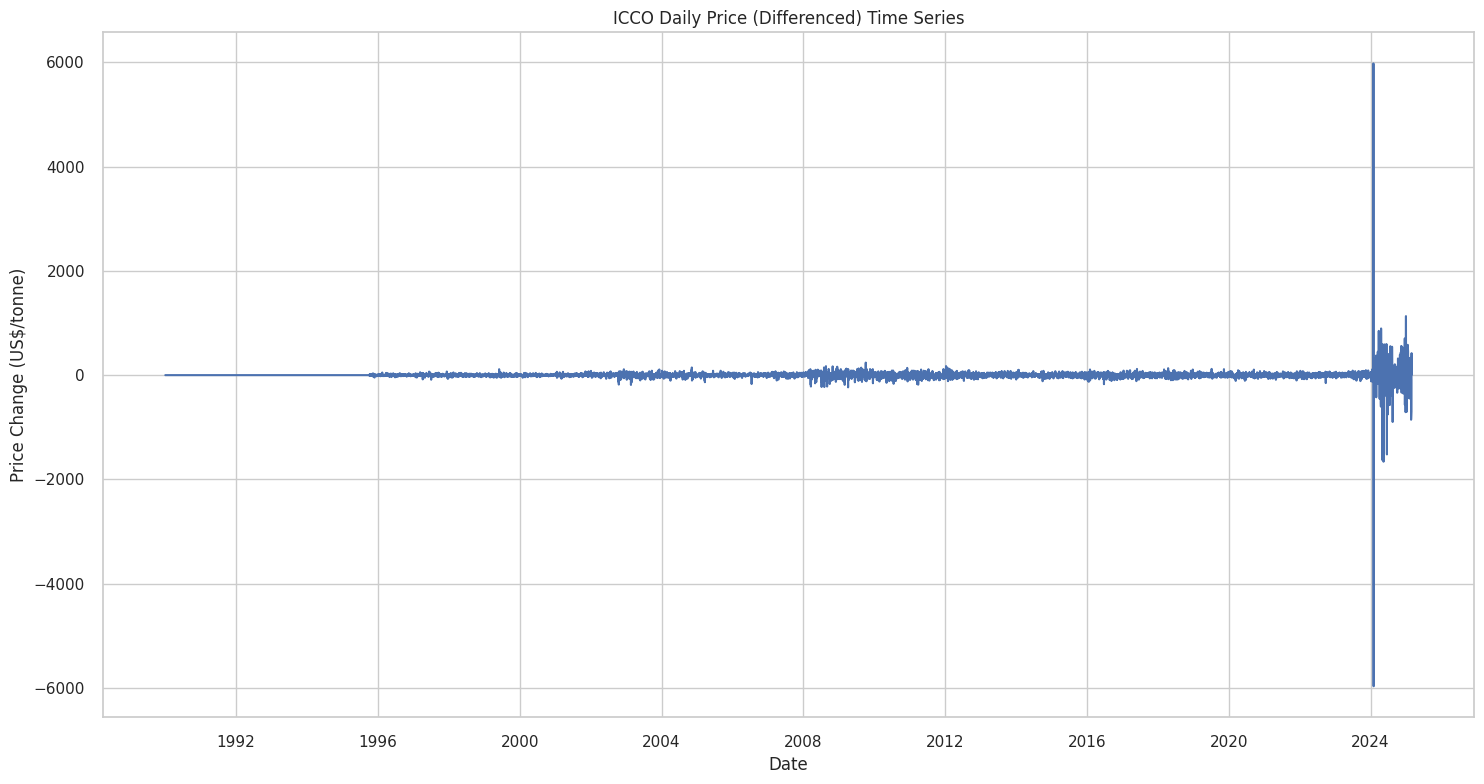

ADF Statistic for ICCO Daily Price (differenced): -19.181477403914126
p-value: 0.0
Critical Values:
	1%: -3.430899362543065
	5%: -2.8617827898455803
	10%: -2.566899231978117
The series ICCO Daily Price (differenced) is stationary (reject H0)


In [34]:
# Check for stationarity using Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, name):
    """Check stationarity of a time series using ADF test."""
    result = adfuller(series.dropna())
    print(f'ADF Statistic for {name}: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    
    # Interpret the result
    if result[1] <= 0.05:
        print(f"The series {name} is stationary (reject H0)")
        return True
    else:
        print(f"The series {name} is non-stationary (fail to reject H0)")
        return False

# Check stationarity of ICCO price
is_stationary = check_stationarity(merged_df['icco_daily_price'], 'ICCO Daily Price')

# If not stationary, apply differencing
if not is_stationary:
    icco_diff = merged_df['icco_daily_price'].diff().dropna()
    
    # Plot differenced series
    plt.figure(figsize=(15, 8))
    plt.plot(merged_df.index[1:], icco_diff)
    plt.title('ICCO Daily Price (Differenced) Time Series')
    plt.xlabel('Date')
    plt.ylabel('Price Change (US$/tonne)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("icco_price_differenced.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Check stationarity of differenced series
    is_diff_stationary = check_stationarity(icco_diff, 'ICCO Daily Price (differenced)')



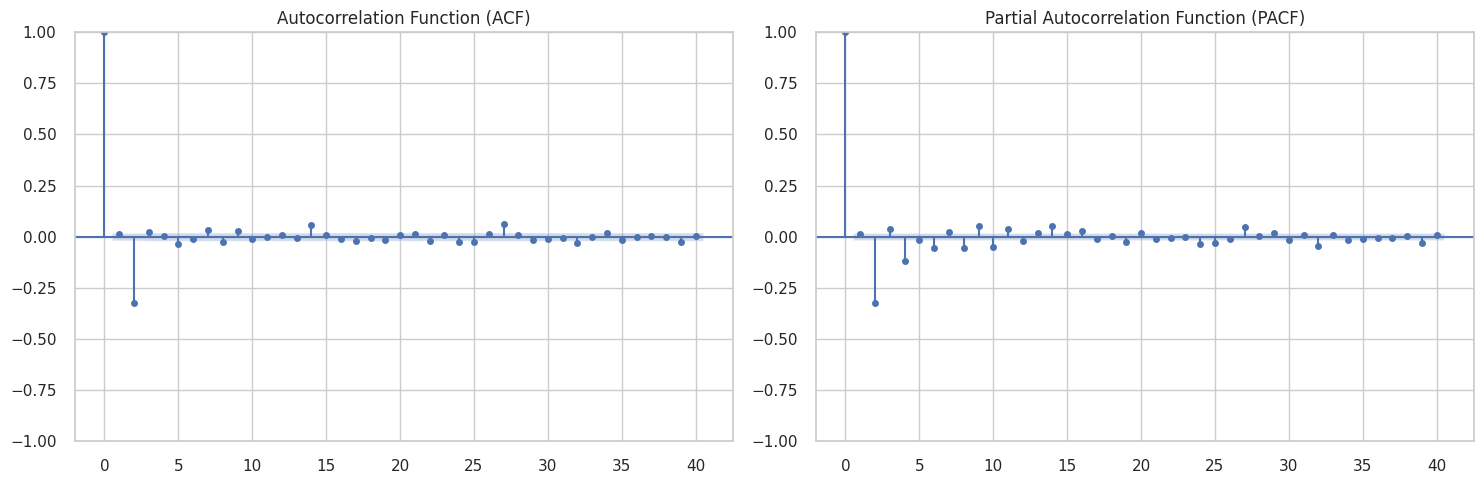

In [35]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot ACF
plot_acf(icco_diff, lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(icco_diff, lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.savefig("acf_pacf_plot.png", dpi=300, bbox_inches='tight')
plt.show()


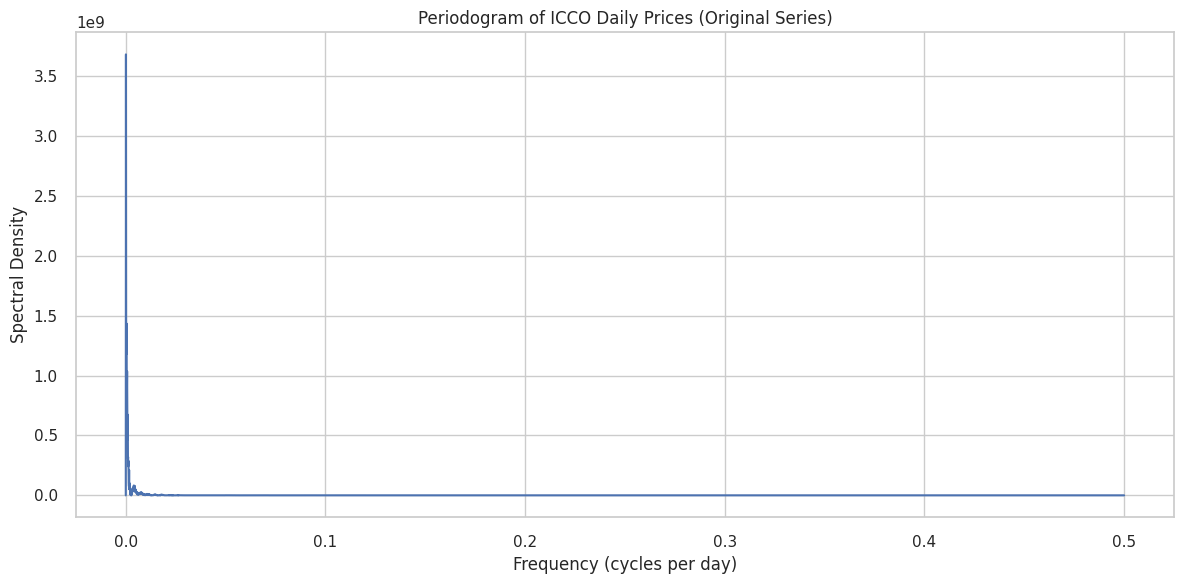

Top 10 Dominant Frequencies (Original Series):
1. Frequency: 0.00008 → Period: 11946.00 days | Power: 3680438412.09670
2. Frequency: 0.00042 → Period: 2389.20 days | Power: 1433398932.61254
3. Frequency: 0.00017 → Period: 5973.00 days | Power: 1346298375.92581
4. Frequency: 0.00025 → Period: 3982.00 days | Power: 1238409860.52116
5. Frequency: 0.00033 → Period: 2986.50 days | Power: 1178178593.44636
6. Frequency: 0.00067 → Period: 1493.25 days | Power: 1035598954.43650
7. Frequency: 0.00059 → Period: 1706.57 days | Power: 945968056.93783
8. Frequency: 0.00050 → Period: 1991.00 days | Power: 755708438.70602
9. Frequency: 0.00075 → Period: 1327.33 days | Power: 678408185.43615
10. Frequency: 0.00100 → Period: 995.50 days | Power: 673110852.84580


In [36]:
# Extract the original ICCO daily price series
original_series = merged_df['icco_daily_price'].dropna()

# Compute the periodogram
freqs, power = periodogram(original_series)

# Plot the periodogram
plt.figure(figsize=(12, 6))
plt.plot(freqs, power)
plt.title('Periodogram of ICCO Daily Prices (Original Series)')
plt.xlabel('Frequency (cycles per day)')
plt.ylabel('Spectral Density')
plt.grid(True)
plt.tight_layout()
plt.savefig("periodogram_icco_prices.png", dpi=300, bbox_inches='tight')
plt.show()

# Identify the 10 most dominant frequencies
top_indices = np.argsort(power)[-10:][::-1]
top_freqs = freqs[top_indices]
top_powers = power[top_indices]

print("Top 10 Dominant Frequencies (Original Series):")
for i in range(10):
    freq = top_freqs[i]
    period = 1 / freq if freq != 0 else np.nan
    print(f"{i+1}. Frequency: {freq:.5f} → Period: {period:.2f} days | Power: {top_powers[i]:.5f}")

In [16]:
# Split data for training and testing (80/20 split)
train_size = int(len(merged_df) * 0.80)
valid_size = int(len(merged_df) * 0.10)
train_data = merged_df.iloc[:train_size]
valid_data = merged_df.iloc[train_size : train_size + valid_size]
test_data = merged_df.iloc[train_size + valid_size:]

print(f"Training data: {train_data.shape} ({train_data.index.min()} to {train_data.index.max()})")
print(f"Validation data: {valid_data.shape} ({valid_data.index.min()} to {valid_data.index.max()})")
print(f"Test data: {test_data.shape} ({test_data.index.min()} to {test_data.index.max()})")


Training data: (9556, 7) (1990-01-01 00:00:00 to 2018-07-05 00:00:00)
Validation data: (1194, 7) (2018-07-06 00:00:00 to 2021-10-13 00:00:00)
Test data: (1196, 7) (2021-10-14 00:00:00 to 2025-02-27 00:00:00)


In [17]:
def create_fourier_terms(index, period=365, order=3):
    """Create Fourier terms for a given datetime index."""
    t = index.map(pd.Timestamp.toordinal)  # Convert dates to integers
    
    fourier_terms = pd.DataFrame(index=index)
    for k in range(1, order + 1):
        fourier_terms[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        fourier_terms[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    
    return fourier_terms

{'RMSE': 196.55646455450716, 'RMSLE': 0.08368105048003426, 'MAPE': 7.10247904911835, 'R^2': -0.7863606534085119}


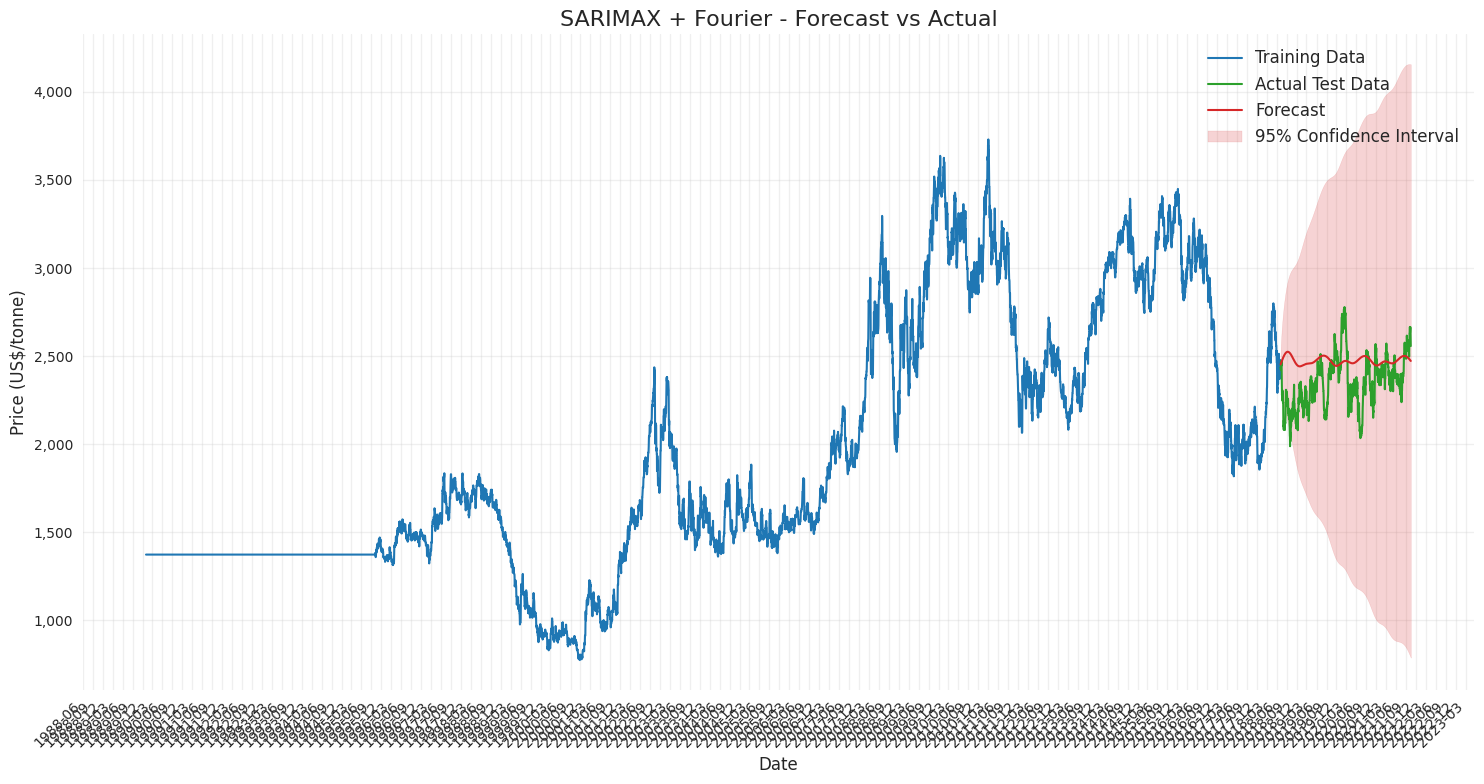

In [18]:
# Generate Fourier features for train and validation sets
X_train = create_fourier_terms(train_data.index, period=365, order=3)
X_valid = create_fourier_terms(valid_data.index, period=365, order=3)

# Fit your model
sarima_model = SARIMAX(
    train_data['icco_daily_price'],
    exog=X_train,
    order=(2, 1, 2),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

# Forecast using the validation set's Fourier features
forecast_steps = len(valid_data)
sarima_forecast = sarima_model.get_forecast(steps=forecast_steps, exog=X_valid)
forecast_mean = sarima_forecast.predicted_mean
forecast_mean.index = valid_data.index[:len(forecast_mean)]

conf_int = sarima_forecast.conf_int()

# Calculate metrics and plot forecast
metrics = calculate_metrics(valid_data['icco_daily_price'], forecast_mean)

plot_forecast(
    train_data,
    valid_data,
    forecast_mean,
    model_name='SARIMAX + Fourier',
    confidence_intervals=(conf_int.iloc[:, 0], conf_int.iloc[:, 1])
)

print(metrics)

ARIMA metrics: {'RMSE': 179.21897774780695, 'RMSLE': 0.07659148993728522, 'MAPE': 6.445568719054753, 'R^2': -0.485123164462709}


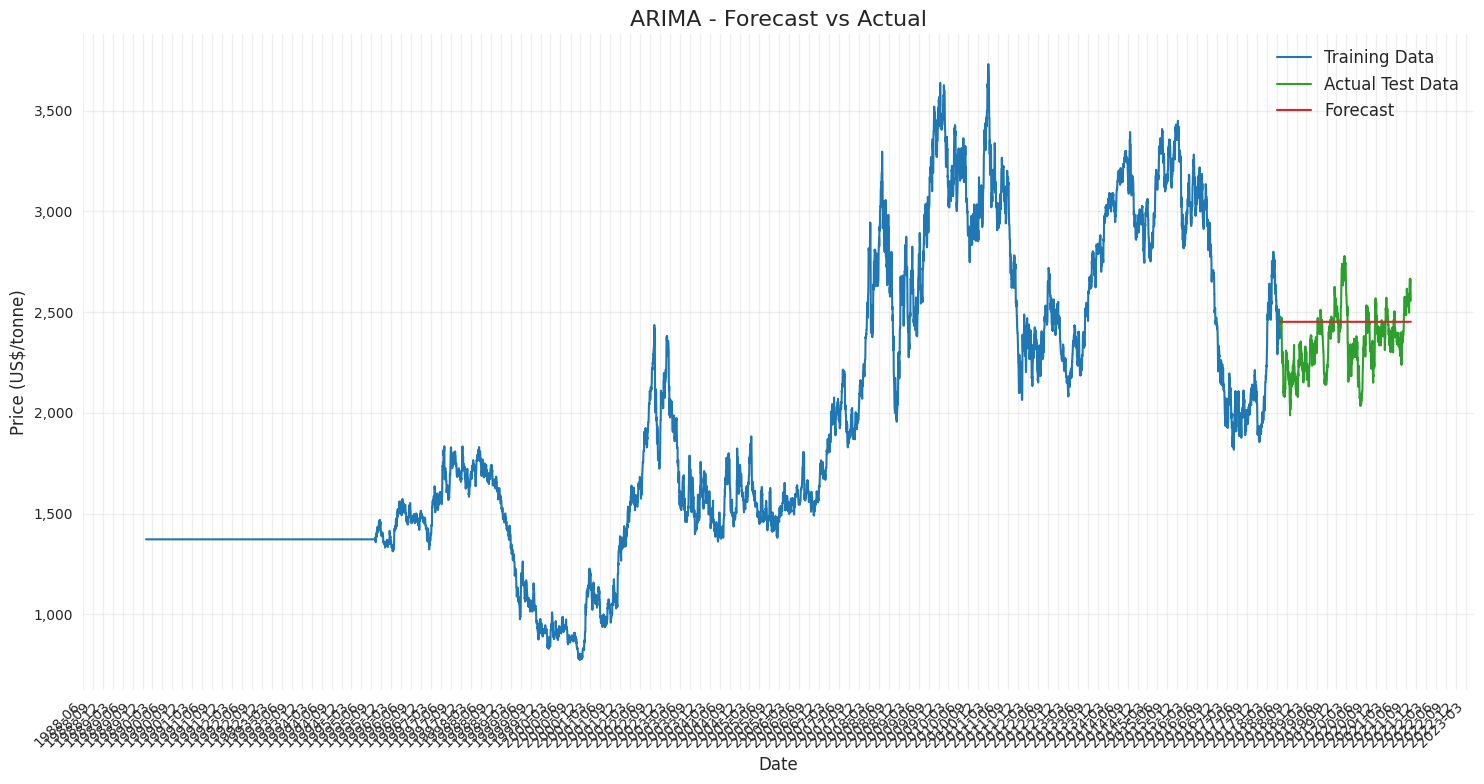

In [19]:
# Fit ARIMA model (non-seasonal counterpart)
arima_model = ARIMA(train_data['icco_daily_price'], order=(2, 1, 2)).fit()

# Forecast
arima_forecast = arima_model.forecast(steps=len(valid_data))
arima_forecast.index = valid_data.index[:len(arima_forecast)]  # Align index

# Plot
plot_forecast(train_data, valid_data, arima_forecast, model_name='ARIMA')

# Evaluate
arima_metrics = calculate_metrics(valid_data['icco_daily_price'], arima_forecast)
print("ARIMA metrics:", arima_metrics)

Double Exponential Smoothing metrics: {'RMSE': 212.3071466252241, 'RMSLE': 0.08984145670542976, 'MAPE': 8.056676642251198, 'R^2': -1.0841247329539883}


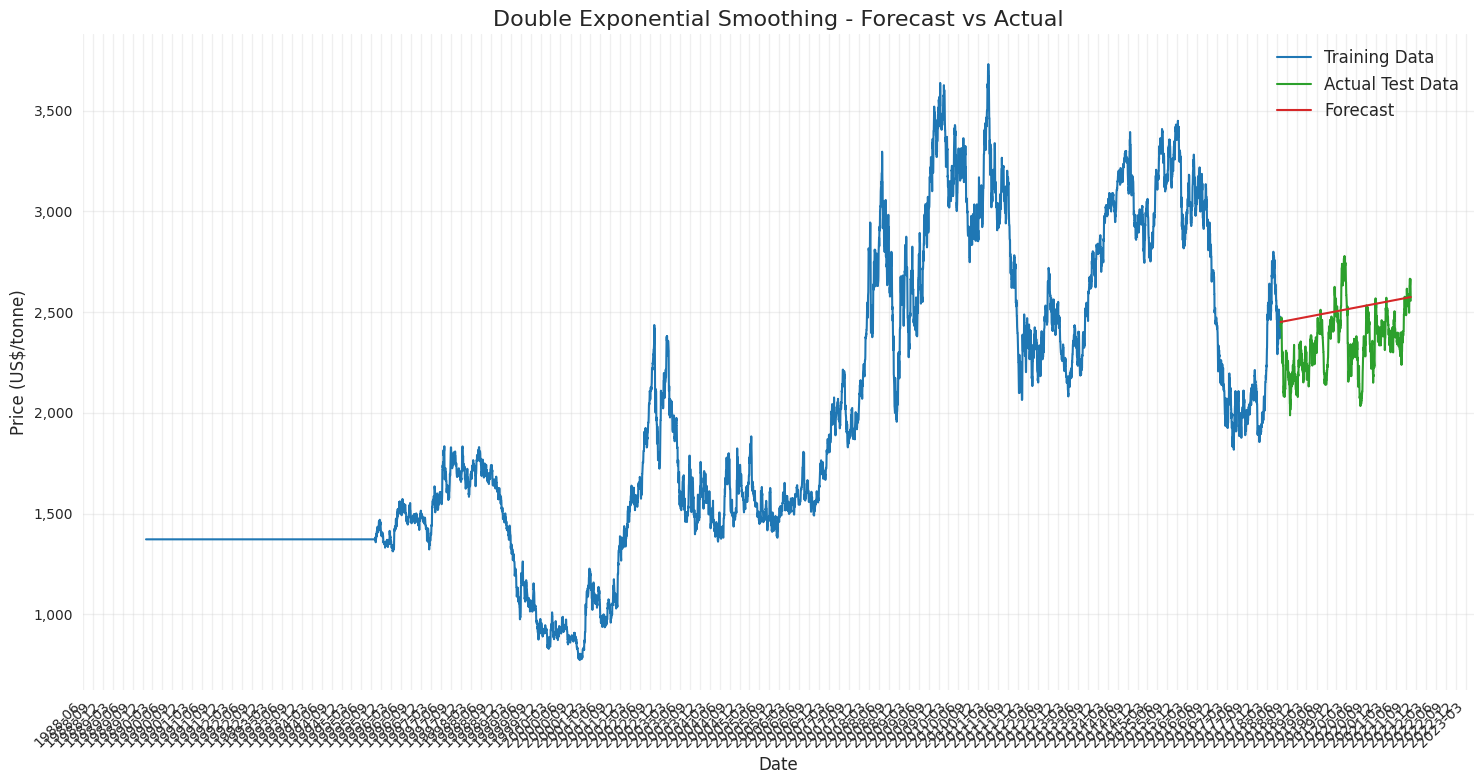

In [20]:
# Fit Double Exponential Smoothing (trend only, no seasonality)
des_model = ExponentialSmoothing(
    train_data['icco_daily_price'],
    trend='add',
    seasonal=None,
    initialization_method="estimated"
).fit()

# Forecast for validation period
des_forecast = des_model.forecast(steps=len(valid_data))
des_forecast.index = valid_data.index[:len(des_forecast)]  # Align index

# Plot
plot_forecast(train_data, valid_data, des_forecast, model_name='Double Exponential Smoothing')


# Evaluate
des_metrics = calculate_metrics(valid_data['icco_daily_price'], des_forecast)
print("Double Exponential Smoothing metrics:", des_metrics)

In [21]:
# Create Fourier terms
fourier_train = create_fourier_terms(train_data.index)
fourier_valid = create_fourier_terms(valid_data.index)

SARIMAX with TAVG + PRCP + Fourier metrics: {'RMSE': 170.80474986360258, 'RMSLE': 0.07302539685715882, 'MAPE': 6.010926833177735, 'R^2': -0.3489453888384315}


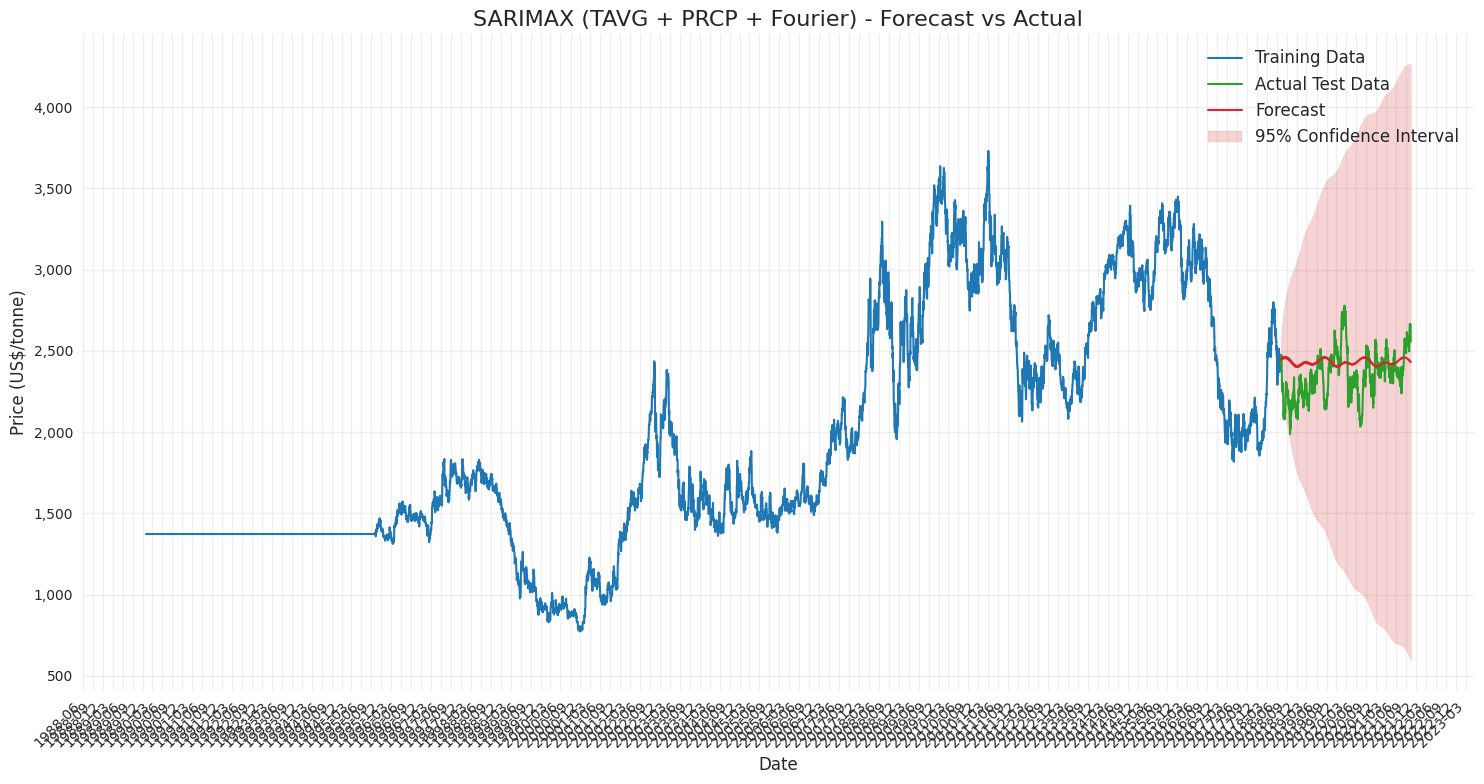

In [22]:
X_train = pd.concat([train_data[['TAVG', 'PRCP']], fourier_train], axis=1)
X_valid = pd.concat([valid_data[['TAVG', 'PRCP']], fourier_valid], axis=1)

y_train = train_data['icco_daily_price']

sarimax_model = SARIMAX(
    y_train,
    exog=X_train,
    order=(2, 1, 2), 
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

sarimax_forecast = sarimax_model.get_forecast(steps=len(X_valid), exog=X_valid)
forecast_mean = sarimax_forecast.predicted_mean
forecast_mean.index = valid_data.index[:len(forecast_mean)]
conf_int = sarimax_forecast.conf_int()

plot_forecast(
    train_data,
    valid_data,
    forecast_mean,
    model_name='SARIMAX (TAVG + PRCP + Fourier)',
    confidence_intervals=(conf_int.iloc[:, 0], conf_int.iloc[:, 1])
)

sarimax_metrics = calculate_metrics(valid_data['icco_daily_price'], forecast_mean)
print("SARIMAX with TAVG + PRCP + Fourier metrics:", sarimax_metrics)


SARIMAX (Exog + Fourier) metrics: {'RMSE': 165.88492677328685, 'RMSLE': 0.07051906946089655, 'MAPE': 5.667061928224649, 'R^2': -0.27235508939371234}


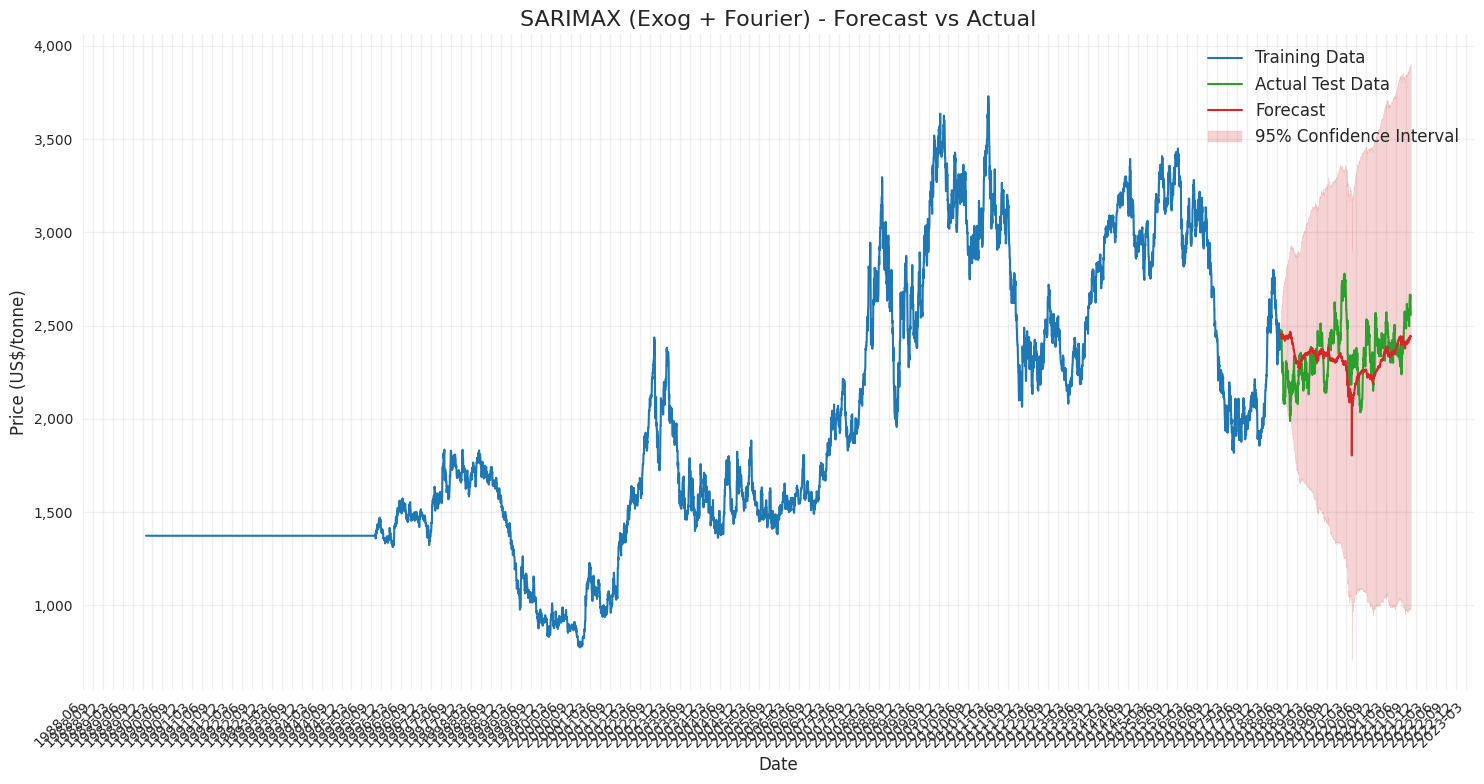

In [23]:
# Original exogenous variables
exog_feat = ['TAVG', 'PRCP', 'cnft_price', 'oil_price', 'sp500_change']

# Combine them with Fourier terms
X_train_exog = pd.concat([train_data[exog_feat], fourier_train], axis=1)
X_valid_exog = pd.concat([valid_data[exog_feat], fourier_valid], axis=1)
y_train_exog = train_data['icco_daily_price']
y_valid_exog = valid_data['icco_daily_price']

sarimax_exog_fourier = SARIMAX(
    y_train_exog,
    exog=X_train_exog,
    order=(2, 1, 2),
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

forecast_exog_fourier = sarimax_exog_fourier.get_forecast(steps=len(X_valid_exog), exog=X_valid_exog)
forecast_mean_exog_fourier = forecast_exog_fourier.predicted_mean
forecast_mean_exog_fourier.index = valid_data.index[:len(forecast_mean_exog_fourier)]
conf_int_exog_fourier = forecast_exog_fourier.conf_int()

plot_forecast(
    train_data,
    valid_data,
    forecast_mean_exog_fourier,
    model_name='SARIMAX (Exog + Fourier)',
    confidence_intervals=(conf_int_exog_fourier.iloc[:, 0], conf_int_exog_fourier.iloc[:, 1])
)

metrics_exog_fourier = calculate_metrics(y_valid_exog, forecast_mean_exog_fourier)
print("SARIMAX (Exog + Fourier) metrics:", metrics_exog_fourier)

SARIMAX (Exogenous Only) metrics: {'RMSE': 161.01002244161205, 'RMSLE': 0.06839302634154465, 'MAPE': 5.4861040721972625, 'R^2': -0.19867183687749201}


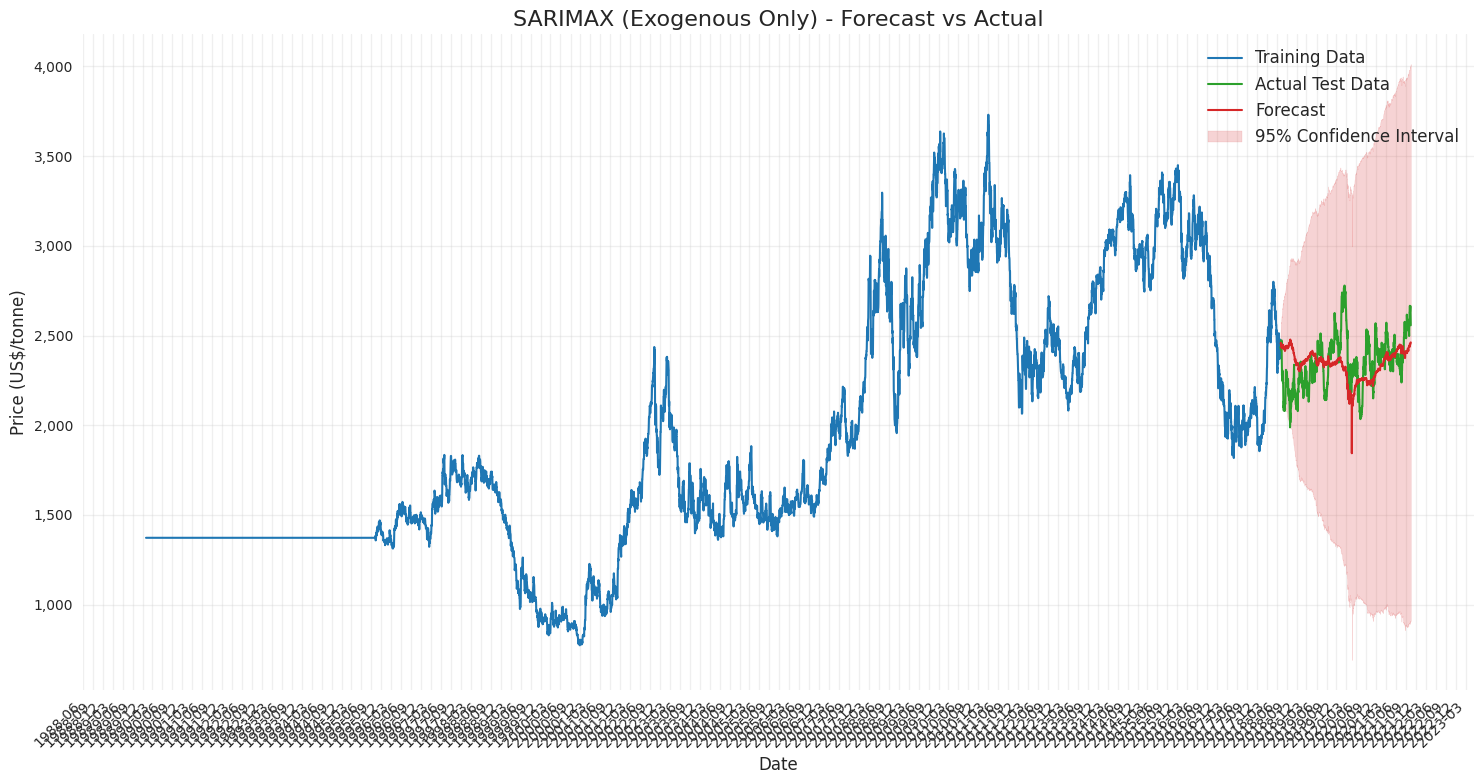

In [24]:
# Define the exogenous features to include
exog_feat = ['TAVG', 'PRCP', 'cnft_price', 'oil_price', 'sp500_change']

# Extract training and validation data for SARIMAX
X_train_exog = train_data[exog_feat]
X_valid_exog = valid_data[exog_feat]
y_train_exog = train_data['icco_daily_price']
y_valid_exog = valid_data['icco_daily_price']

# Fit SARIMAX model (no seasonal component)
sarimax_exog_only = SARIMAX(y_train_exog,
                            exog=X_train_exog,
                            order=(2, 1, 2),
                            seasonal_order=(0, 0, 0, 0),
                            enforce_stationarity=False,
                            enforce_invertibility=False).fit()

# Forecast
forecast_exog_only = sarimax_exog_only.get_forecast(steps=len(X_valid_exog), exog=X_valid_exog)
forecast_mean_exog_only = forecast_exog_only.predicted_mean
forecast_mean_exog_only.index = valid_data.index[:len(forecast_mean_exog_only)]
conf_int_exog_only = forecast_exog_only.conf_int()

# Plot
plot_forecast(train_data, valid_data, forecast_mean_exog_only,
              model_name='SARIMAX (Exogenous Only)',
              confidence_intervals=(conf_int_exog_only.iloc[:, 0], conf_int_exog_only.iloc[:, 1]))

# Evaluate
metrics_exog_only = calculate_metrics(y_valid_exog, forecast_mean_exog_only)
print("SARIMAX (Exogenous Only) metrics:", metrics_exog_only)

SARIMAX + GARCH metrics: {'RMSE': 161.01002244161205, 'RMSLE': 0.06839302634154465, 'MAPE': 5.4861040721972625, 'R^2': -0.19867183687749201}


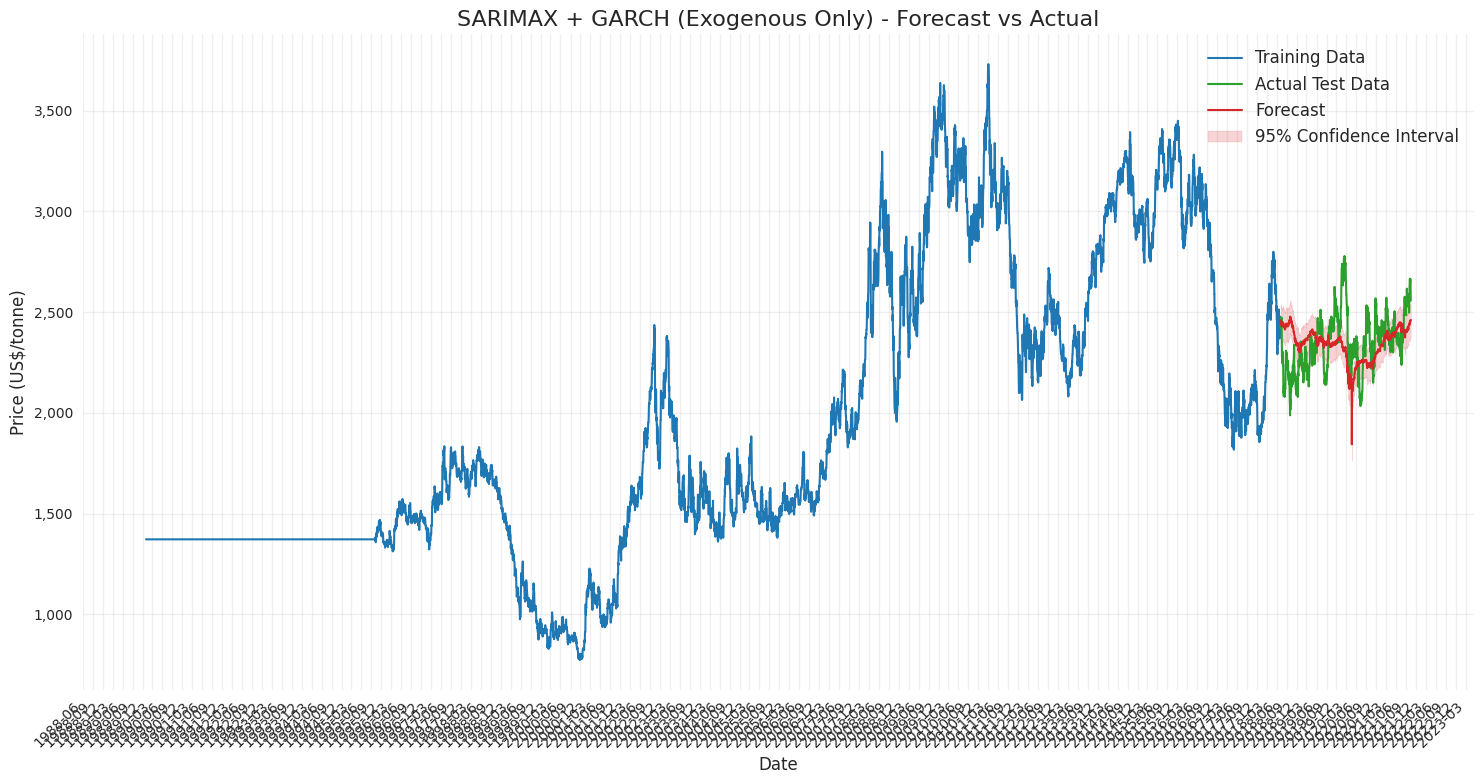

In [25]:
# Get SARIMAX residuals
sarimax_resid = sarimax_exog_only.resid.dropna()

# Fit GARCH(1,1) model to residuals
garch_model = arch_model(sarimax_resid, vol='GARCH', p=1, q=1)
garch_result = garch_model.fit(disp='off')

# Forecast conditional variance for validation set
garch_forecast = garch_result.forecast(horizon=len(X_valid_exog))
garch_variance = garch_forecast.variance.values[-1]  # shape: (n_obs, horizon)

# Get SARIMAX forecast for mean
sarimax_forecast_exog = sarimax_exog_only.get_forecast(steps=len(X_valid_exog), exog=X_valid_exog)
forecast_mean_exog = sarimax_forecast_exog.predicted_mean
forecast_mean_exog.index = valid_data.index[:len(forecast_mean_exog)]

# Combine forecast + GARCH volatility as confidence bands
garch_std = np.sqrt(garch_variance)
upper_bound = forecast_mean_exog + 2 * garch_std
lower_bound = forecast_mean_exog - 2 * garch_std

# Plot forecast with GARCH uncertainty
plot_forecast(train_data, valid_data, forecast_mean_exog,
              model_name='SARIMAX + GARCH (Exogenous Only)',
              confidence_intervals=(lower_bound, upper_bound))

# Evaluate
sarimax_garch_metrics = calculate_metrics(valid_data['icco_daily_price'], forecast_mean_exog)
print("SARIMAX + GARCH metrics:", sarimax_garch_metrics)

In [26]:
# Combine metrics into dictionary
metrics_dict = {
    'SARIMA': metrics,
    'ARIMA': arima_metrics,
    'DES': des_metrics,
    'SARIMAX (TAVG + PRCP)': sarimax_metrics,
    'SARIMAX (Exog Only)': metrics_exog_only,
    'SARIMAX + GARCH (Exog Only)': sarimax_garch_metrics,
    'SARIMAX + Exog' : metrics_exog_fourier
}

# Create a formatted table
metrics_table = create_metrics_table(metrics_dict)
display(metrics_table)


,RMSE,RMSLE,MAPE,R^2
SARIMAX (Exog Only),161.0100,0.0684,5.4861,-0.1987
SARIMAX + GARCH (Exog Only),161.0100,0.0684,5.4861,-0.1987
SARIMAX + Exog,165.8849,0.0705,5.6671,-0.2724
SARIMAX (TAVG + PRCP),170.8047,0.0730,6.0109,-0.3489
ARIMA,179.2190,0.0766,6.4456,-0.4851
SARIMA,196.5565,0.0837,7.1025,-0.7864
DES,212.3071,0.0898,8.0567,-1.0841


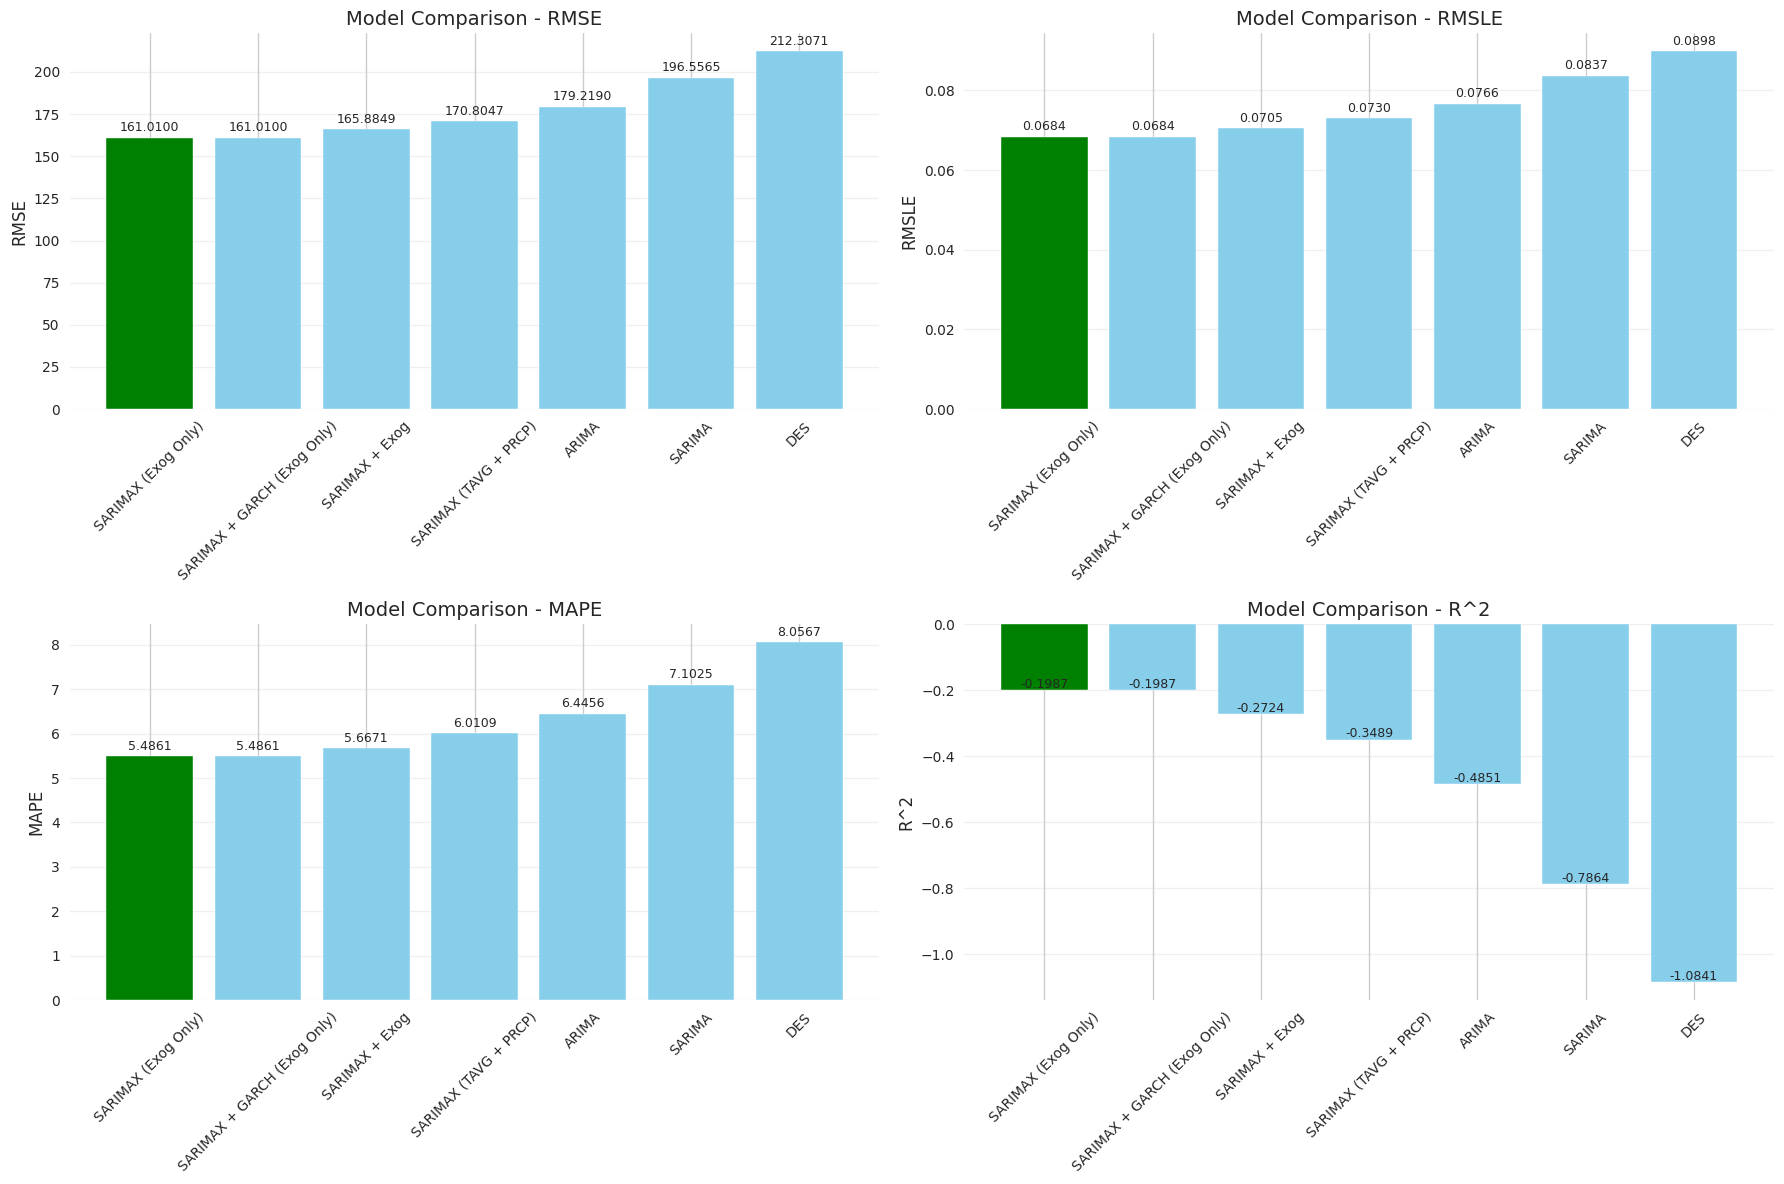

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
metrics_list = ['RMSE', 'RMSLE', 'MAPE', 'R^2']

for ax, metric in zip(axes.flatten(), metrics_list):
    if metric.upper() in ['RMSE', 'MAPE', 'RMSLE']:
        sorted_df = metrics_table.sort_values(metric)
        best_idx = 0
    else:
        sorted_df = metrics_table.sort_values(metric, ascending=False)
        best_idx = 0

    colors = ['skyblue'] * len(sorted_df)
    colors[best_idx] = 'green'
    
    bars = ax.bar(sorted_df.index, sorted_df[metric], color=colors)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01*max(sorted_df[metric]),
                f'{height:.4f}', ha='center', va='bottom', fontsize=9)
    
    ax.set_title(f'Model Comparison - {metric}', fontsize=14)
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("model_comparison_metrics.png", dpi=300, bbox_inches='tight')
plt.show()


Test Set Performance (SARIMAX + GARCH): {'RMSE': 3122.7587956125235, 'RMSLE': 0.6466845674808621, 'MAPE': 30.43067296785898, 'R^2': -0.5039713717961223}


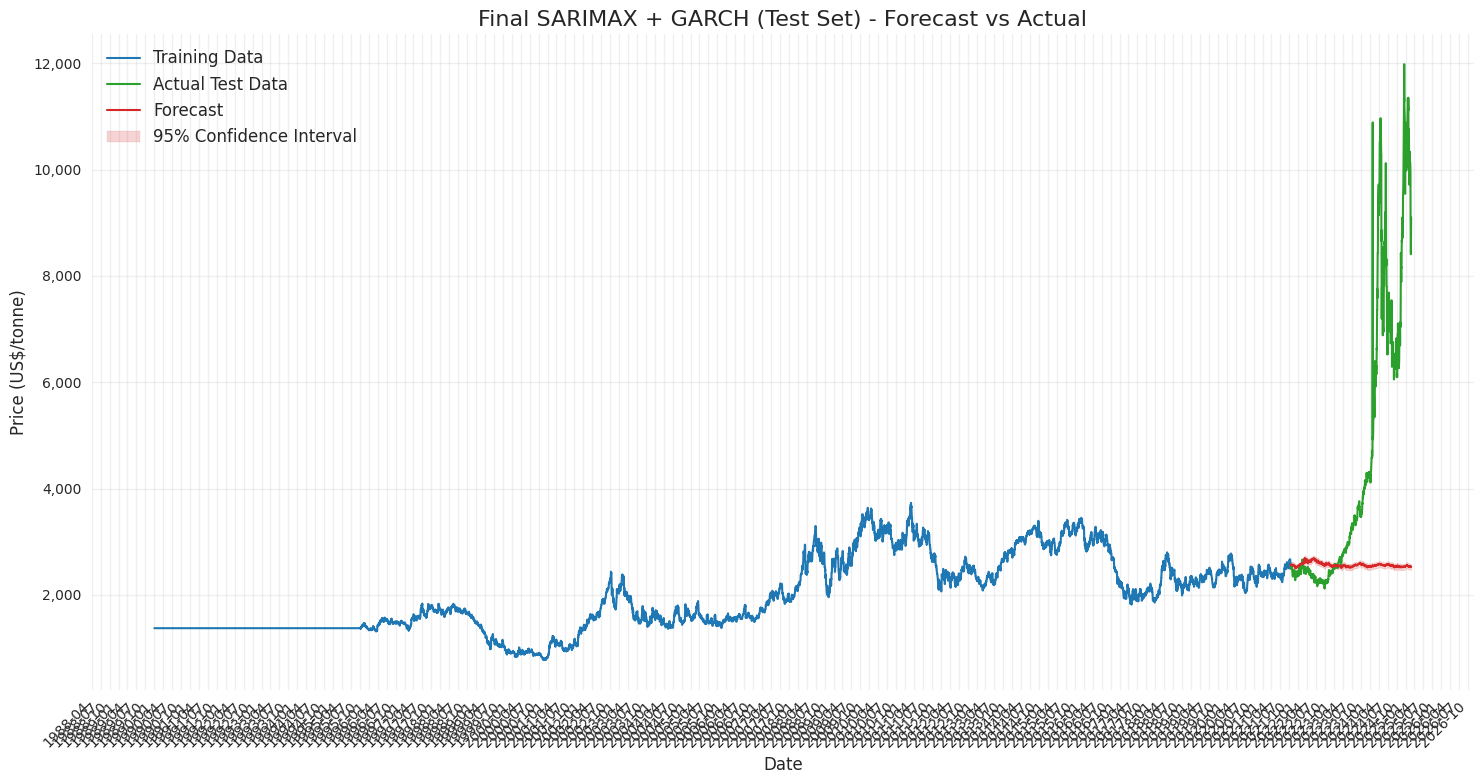

In [28]:
# === FINAL MODEL: SARIMAX + GARCH ===
# Combine train + validation
final_train = pd.concat([train_data, valid_data])
y_final = final_train['icco_daily_price']
X_final = final_train[exog_feat]

# Test set
X_test = test_data[exog_feat]
y_test = test_data['icco_daily_price']

# Step 1: Fit SARIMAX on full training data
sarimax_final = SARIMAX(y_final,
                        exog=X_final,
                        order=(2, 1, 2),
                        seasonal_order=(0, 0, 0, 0),
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit()

# Step 2: Get residuals from final SARIMAX model
resid_final = sarimax_final.resid.dropna()

# Step 3: Fit GARCH on SARIMAX residuals
garch_final = arch_model(resid_final, vol='GARCH', p=1, q=1)
garch_final_result = garch_final.fit(disp='off')

# Step 4: Forecast mean from SARIMAX and volatility from GARCH
sarimax_forecast_final = sarimax_final.get_forecast(steps=len(X_test), exog=X_test)
forecast_mean_final = sarimax_forecast_final.predicted_mean
forecast_mean_final.index = test_data.index[:len(forecast_mean_final)]

# Forecast variance from GARCH
garch_forecast_final = garch_final_result.forecast(horizon=len(X_test))
garch_var_test = garch_forecast_final.variance.values[-1]
garch_std_test = np.sqrt(garch_var_test)
upper_test = forecast_mean_final + 2 * garch_std_test
lower_test = forecast_mean_final - 2 * garch_std_test

# Step 5: Plot and evaluate
plot_forecast(final_train, test_data, forecast_mean_final,
              model_name='Final SARIMAX + GARCH (Test Set)',
              confidence_intervals=(lower_test, upper_test))
plt.savefig("final_sarimax_garch_testset.png", dpi=300, bbox_inches='tight')

# Step 6: Compute test metrics
final_test_metrics = calculate_metrics(y_test, forecast_mean_final)
print("Test Set Performance (SARIMAX + GARCH):", final_test_metrics)


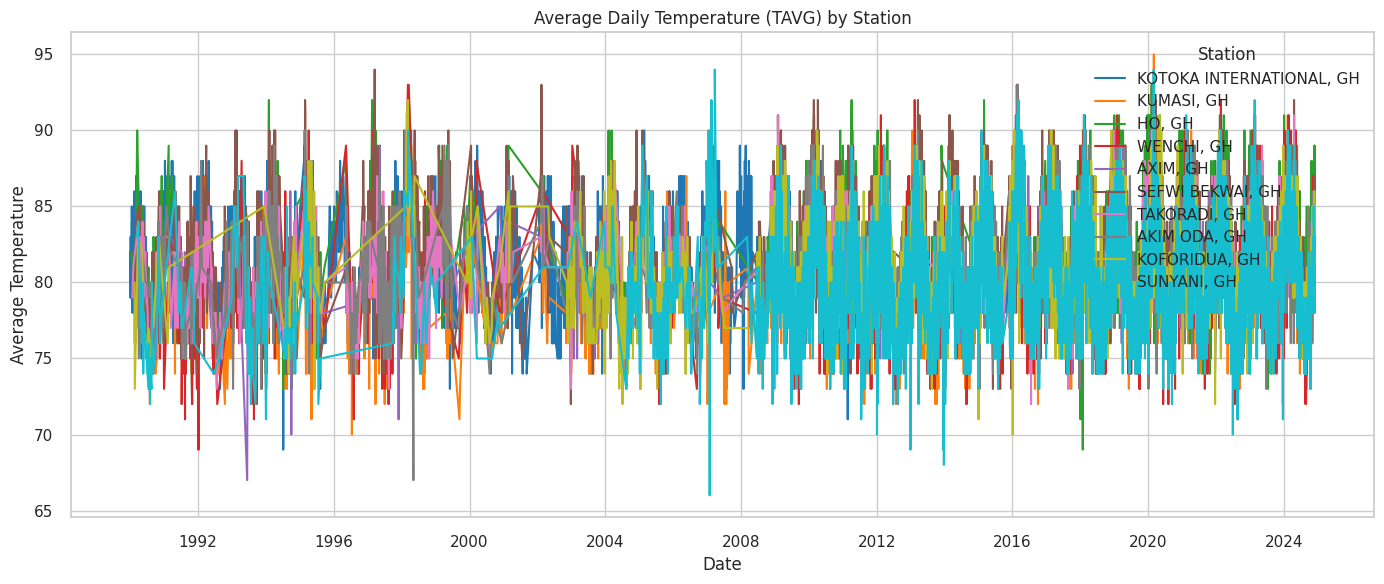

In [29]:
# Make sure DATE is in datetime format
ghana_df['DATE'] = pd.to_datetime(ghana_df['DATE'])

# Drop rows with missing TAVG
ghana_clean = ghana_df.dropna(subset=['TAVG'])

# Set style
sns.set(style="whitegrid")

# Plot using seaborn
plt.figure(figsize=(14, 6))
sns.lineplot(data=ghana_clean, x='DATE', y='TAVG', hue='NAME', palette='tab10')

# Plot labels and legend
plt.title('Average Daily Temperature (TAVG) by Station')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.legend(title='Station', loc='upper right')
plt.tight_layout()
plt.savefig("average_temp_by_station.png", dpi=300, bbox_inches='tight')
plt.show()